In [8]:
# Importing necessary libraries
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import scipy as sp


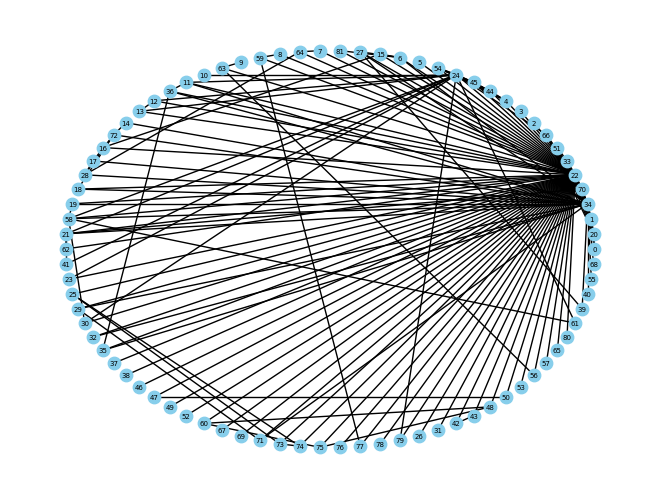

In [16]:
#IMPORTING DATABASE
edges_filename = "edges.csv"
nodes_filename = "nodes.csv"

df_edges = pd.read_csv(edges_filename)
df_nodes = pd.read_csv(nodes_filename)

# Create the graph using the edges CSV
G = nx.from_pandas_edgelist(df_edges, '# source', ' target', create_using=nx.DiGraph())

# Circular plot
nx.draw_circular(G, with_labels="True",node_color='skyblue', edge_color='black', node_size=80, font_size=5, arrows=False)

In [17]:
def simulation_threshold_plot(G,threshold,I,time_limit): #Parameters: the graph, the threshold,
    #the initial outbreak, a limit on the number of iteration to avoid a program never stopping

    #   Initialization of the types
    for node in G.nodes():
        G.nodes[node]['category'] ='Inactive'

    for node in I: #initial outbreak
        G.nodes[node]['category'] ='Active'

    n=G.number_of_nodes()
    
    # Plot using the type for the coloring
    color_map = {'Inactive':'w', 'Active':'r'}  # Map from type to color
    nx.draw_circular(G,node_size=150,with_labels=False, node_color=[color_map[G.nodes[node]['category']] for node in G]) # Plot using the map to decide the color
    plt.show()
    
    # Iteration
    t=1
    
    while t<=time_limit-1:
        t=t+1
                
        for node in G.nodes(): # go over the nodes
            neighbor_active=0   # initialize a counter for the number of active neighbor.
            for neighbor in G.neighbors(node): # go over neighbors and add one for each active neighbor.
                
                if G.nodes[neighbor]['category']=='Active':
                    neighbor_active=neighbor_active+1
                else:
                    neighbor_active=neighbor_active
            
            if neighbor_active>=threshold: # Check if the threshold is reached. If so active the node
                G.nodes[node]['category']='Active'
                
        #we plot only at the end of the iteration
        nx.draw_circular(G,node_size=150,with_labels=False, node_color=[color_map[G.nodes[node]['category']] for node in G]) 
        plt.show()


In [ ]:
I= [4]
simulation_threshold_plot(G,2,I,4)


In [15]:
def simulation_threshold_active_end(G,threshold,I,time_limit):

    #   Initialization of the types
    for node in G.nodes():
        G.nodes[node]['category'] ='Inactive'

    for node in I:
        G.nodes[node]['category'] ='Active'

    n=G.number_of_nodes()
    
    # Iteration
    t=1
    
    while t<=time_limit-1:
        t=t+1
                
        for node in G.nodes(): # go over the n odes
            neighbor_active=0   # initialize a counter for the number of active neighbor.
            for neighbor in G.neighbors(node): # go over neighbors and add one for each active nieghbor.
                
                if G.nodes[neighbor]['category']=='Active':
                    neighbor_active=neighbor_active+1
                else:
                    neighbor_active=neighbor_active
            
            if neighbor_active>=threshold:
                G.nodes[node]['category']='Active'
        
    active=0   # initialize a counter for the number of active nodes.
    
    for node in G.nodes(): # go over all nodes and add one for each active nieghbor.
        if G.nodes[node]['category']=='Active':
            active=active+1
        else:
            active=active        
    
    return active # return the number of active nodes
     

In [3]:
def comparison_centrality_threshold_limit(G,threshold,time_limit):
    
    data_y=[] # empty list where we will stock the number of nodes active for each starting outbreak
    
    for node in G.nodes():
        y=simulation_threshold_active_end(G,threshold,[node],time_limit) # simulate from an outbreak at node "node"
        data_y.append(y) # add the value to the list
        
    return data_y